In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.utils import shuffle
import statsmodels.api as sm

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Load Dataset with all columns
# Making the data columns datetime objects with the parse_dates attribute
bikeshare_machine = pd.read_csv('/Users/matthewcassi/Documents/Bike-Sharing-Dataset/less_bikeshare_lat_lon.csv', 
                        parse_dates=['Start date', 'End date', 'start_date_short', 'end_date_short'])
# Removing the Unnamed column
bikeshare_machine.drop('Unnamed: 0', 1, inplace=True)

In [4]:
# creating a list of columns which will be used to create the list of columns to keep for the machine
# learning piece
list(bikeshare_machine.columns)

['Start date',
 'End date',
 'start_station',
 'start_station_code',
 'end_station',
 'end_station_code',
 'Member Type',
 'start_date_short',
 'end_date_short',
 'time_diff',
 'season',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'hum',
 'windspeed',
 'start_lat',
 'start_lon',
 'end_lat',
 'end_lon',
 'miles']

In [5]:
# Selecting the columns that are needed for the analysis
included_cols = ['start_station',
                 'end_station',
                 'Member Type',
                 'time_diff',
                 'season',
                 'mnth',
                 'holiday',
                 'weekday',
                 'workingday',
                 'weathersit',
                 'temp',
                 'hum',
                 'windspeed']
# Subsetting the dataset so that only the columns above are included
bikeshare_machine = bikeshare_machine[included_cols]
bikeshare_machine.head()

,start_station,end_station,Member Type,time_diff,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,14th & Harvard St NW,16th & Harvard St NW,Registered,1.833,2,3,0,4,1,3,0.268333,0.918333,0.217646
1,Lincoln Park / 13th & East Capitol St NE,13th & H St NE,Registered,3.317,2,3,0,4,1,3,0.268333,0.918333,0.217646
2,14th & R St NW,Massachusetts Ave & Dupont Circle NW,Registered,5.733,2,3,0,4,1,3,0.268333,0.918333,0.217646
3,Park Rd & Holmead Pl NW,15th & P St NW,Registered,8.700,2,3,0,4,1,3,0.268333,0.918333,0.217646
4,37th & O St NW / Georgetown University,21st & M St NW,Registered,7.850,2,3,0,4,1,3,0.268333,0.918333,0.217646


In [6]:
# Make categorical data for columns like month, holiday, etc.
bikeshare_machine['season'] = bikeshare_machine['season'].astype('category')
bikeshare_machine['mnth'] = bikeshare_machine['mnth'].astype('category')
bikeshare_machine['holiday'] = bikeshare_machine['holiday'].astype('category')
bikeshare_machine['weekday'] = bikeshare_machine['weekday'].astype('category')
bikeshare_machine['workingday'] = bikeshare_machine['workingday'].astype('category')
bikeshare_machine['weathersit'] = bikeshare_machine['weathersit'].astype('category')
bikeshare_machine['Member Type'] = bikeshare_machine['Member Type'].astype('category')
bikeshare_machine['start_station'] = bikeshare_machine['start_station'].astype('category')
bikeshare_machine['end_station'] = bikeshare_machine['end_station'].astype('category')

In [7]:
# Update columns names for the dataset
col_names = ['start_station', 'end_station','member_type','time_diff','season','month','holiday',
             'weekday','work_day','weather_cat','temperature','humidity','windspeed']
bikeshare_machine.columns = col_names

In [8]:
# Standardization of windspeed, humidity, and temperature were not all the same
# Values were changed back to their original values (not scaled)
tmin = -8
tmax = 39
hum_max = 100
wind_max = 67
bikeshare_machine['temp'] = bikeshare_machine['temperature'] * (tmax - tmin) + tmin
bikeshare_machine['hum'] = bikeshare_machine['humidity'] * 100
bikeshare_machine['wind'] = bikeshare_machine['windspeed'] * 67

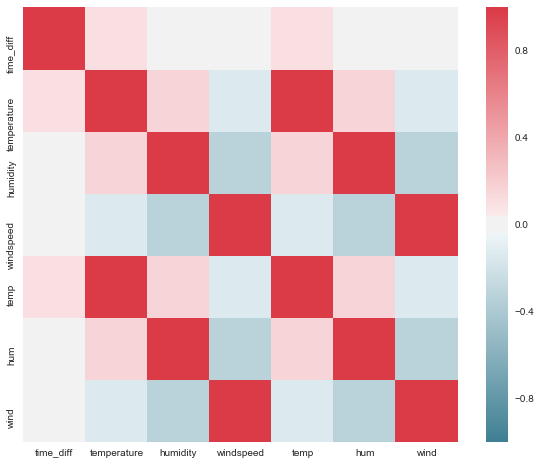

In [9]:
# Checking the correlations between continuous variables
corr = bikeshare_machine.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [10]:
# Turn categorical data into dummy variables. Dropping first dummy for the category variables that have 2 labels
bikeshare_machine = pd.get_dummies(bikeshare_machine, 
                                 columns=['member_type','holiday','work_day'], drop_first=True)
# Turning categorical data into dummy variables. Not dropping the first dummy for categorical data with more
# than 2 labels
bikeshare_machine = pd.get_dummies(bikeshare_machine, 
                                 columns=['start_station','end_station','season','month','weekday','weather_cat'])
bikeshare_machine.head()

,time_diff,temperature,humidity,windspeed,temp,hum,wind,member_type_Registered,holiday_1,work_day_1,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_cat_1,weather_cat_2,weather_cat_3
0,1.833,0.268333,0.918333,0.217646,4.611651,91.8333,14.582282,1,0,1,...,0,0,0,0,1,0,0,0,0,1
1,3.317,0.268333,0.918333,0.217646,4.611651,91.8333,14.582282,1,0,1,...,0,0,0,0,1,0,0,0,0,1
2,5.733,0.268333,0.918333,0.217646,4.611651,91.8333,14.582282,1,0,1,...,0,0,0,0,1,0,0,0,0,1
3,8.700,0.268333,0.918333,0.217646,4.611651,91.8333,14.582282,1,0,1,...,0,0,0,0,1,0,0,0,0,1
4,7.850,0.268333,0.918333,0.217646,4.611651,91.8333,14.582282,1,0,1,...,0,0,0,0,1,0,0,0,0,1


In [11]:
bikeshare_machine = shuffle(bikeshare_machine)
bikeshare_machine.head()

,time_diff,temperature,humidity,windspeed,temp,hum,wind,member_type_Registered,holiday_1,work_day_1,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_cat_1,weather_cat_2,weather_cat_3
828386,31.483,0.348333,0.734583,0.092054,8.371651,73.4583,6.167631,1,0,0,...,1,0,0,0,0,0,0,1,0,0
1076146,7.150,0.454167,0.554583,0.190913,13.345849,55.4583,12.791171,1,0,1,...,0,0,0,0,1,0,0,1,0,0
1128702,20.950,0.361739,0.476957,0.222587,9.001733,47.6957,14.913329,1,0,0,...,1,0,0,0,0,0,0,1,0,0
710769,17.883,0.274783,0.681304,0.155091,4.914801,68.1304,10.391097,1,0,0,...,1,0,0,0,0,0,0,1,0,0
1082813,17.550,0.290833,0.395833,0.421642,5.669151,39.5833,28.250014,0,0,0,...,0,0,0,0,0,0,1,1,0,0


### Model 1 - Remove Some Variables that are correlated

In [12]:
# Leave workday, drop weekdays, leave season, drop month
# Workday overlaps with workday/not workday and months overlap with seasons
remove_cols = ['weekday_0', 'weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6', 
              'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9',
              'month_10','month_11','month_12','temperature','humidity','windspeed', 'time_diff']
X1 = np.matrix(bikeshare_machine.drop(remove_cols, 1))
y1 = bikeshare_machine['time_diff']

In [13]:
# Split the data into training and testing sets and check the shape
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.25, random_state=17)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((914885, 275), (304962, 275), (914885,), (304962,))

In [15]:
# Fit model
model1 = LinearRegression()
model1.fit(X1_train, y1_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
pred1 = model1.predict(X1_test)
cvscores_model1 = cross_val_score(model1, X1_train, y1_train, cv=5)
model1_r = model1.score(X1_test, y1_test)
model1_mse = mean_squared_error(y1_test, pred1)
model1_rmse = np.sqrt(model1_mse)
adjustedr1 = 1 - (1-model1_r)*(len(y1_test)-1)/(len(y1_test)-X1_test.shape[1]-1)

In [17]:
cvscores_model1, model1_r, adjustedr1, model1_mse, model1_rmse

(array([  2.74839332e-01,   2.80822632e-01,   2.79629222e-01,
         -2.99033879e+09,   2.78078363e-01]),
 0.27738868331930755,
 0.27673647707390348,
 99.036121118024781,
 9.9516893600043996)

In [18]:
model1_sm = sm.OLS(y1_train, X1_train).fit()
model1_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              time_diff   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     1302.
Date:                Tue, 05 Dec 2017   Prob (F-statistic):               0.00
Time:                        19:22:33   Log-Likelihood:            -3.3995e+06
No. Observations:              914885   AIC:                         6.800e+06
Df Residuals:                  914613   BIC:                         6.803e+06
Df Model:                         271                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0628      0.002     28.708      0.000       0.058       0.067
x2             0.0007      0.001      0.719      0.472      -0.001       0.003
x3            -0.0127      0.002     -5.670      0.000      -0.017      -0.008
x4           -11.2430      0.030   -369.232      0.000     -11.303     -11.183
x5            -0.5416      0.072     -7.566      0.000      -0.682      -0.401
x6            -1.3904      0.024    -56.919      0.000      -1.438      -1.342
x7             5.1837      0.240     21.557      0.000       4.712       5.655
x8            -1.9614      0.125    -15.717      0.000      -2.206      -1.717
x9             2.8147      0.129     21.896      0.000       2.563       3.067
x10           -2.4275      0.275     -8.829      0.000      -2.966      -1.889
x11           -0.8797      0.130     -6.774      0.000      -1.134      -0.625
x12           -2.7167      0.340     -7.984      0.000      -3.384      -2.050
x13            5.6639      0.353     16.028      0.000       4.971       6.356
x14           -2.9837      0.137    -21.751      0.000      -3.253      -2.715
x15           -1.2725      0.139     -9.175      0.000      -1.544      -1.001
x16           -0.8527      0.131     -6.532      0.000      -1.109      -0.597
x17            2.8580      0.145     19.733      0.000       2.574       3.142
x18           -2.6160      0.153    -17.093      0.000      -2.916      -2.316
x19            0.1512      0.134      1.127      0.260      -0.112       0.414
x20           -2.0287      0.123    -16.534      0.000      -2.269      -1.788
x21           -3.1595      0.126    -25.150      0.000      -3.406      -2.913
x22           -2.5584      0.117    -21.814      0.000      -2.788      -2.329
x23           -2.5536      0.114    -22.329      0.000      -2.778      -2.329
x24           -0.3537      0.156     -2.267      0.023      -0.659      -0.048
x25            3.4724      0.248     14.000      0.000       2.986       3.959
x26            1.6032      0.256      6.268      0.000       1.102       2.104
x27           -2.2866      0.111    -20.656      0.000      -2.504      -2.070
x28           -0.8264      0.311     -2.655      0.008      -1.436      -0.216
x29           -2.3058      0.121    -19.133      0.000      -2.542      -2.070
x30           -2.6850      0.113    -23.798      0.000      -2.906      -2.464
x31           -0.7380      0.140     -5.283      0.000      -1.012      -0.464
x32           -1.6946      0.124    -13.660      0.000      -1.938      -1.451
x33           -1.1500      0.231     -4.980      0.000      -1.603      -0.697
x34           -0.1939      0.162     -1.199      0.231      -0.511       0.123
x35            0.0219      0.213      0.103      0.918      -0.396       0.440
x36           -1.1664      0.132     -8.844      0.000      -1.425      -0.908
x3

### Model 2 - Try reverse of Model 1

In [19]:
# Drop workday, leave weekdays, drop season, leave month
# Workday overlaps with workday/not workday and months overlap with seasons
remove_cols = ['work_day_1','season_1', 'season_2', 'season_3', 'season_4',
               'temperature','humidity','windspeed', 'time_diff']
X2 = bikeshare_machine.drop(remove_cols, 1)
y2 = bikeshare_machine['time_diff']

In [20]:
# Split the data into training and testing sets and check the shape
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.25, random_state=17)
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((914885, 289), (304962, 289), (914885,), (304962,))

In [21]:
# Fit model
model2 = LinearRegression()
model2.fit(X2_train, y2_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
pred2 = model2.predict(X2_test)
cvscores_model2 = cross_val_score(model2, X2_train, y2_train, cv=5)
model2_r = model2.score(X2_test, y2_test)
model2_mse = mean_squared_error(y2_test, pred2)
model2_rmse = np.sqrt(model2_mse)
adjustedr2 = 1 - (1-model2_r)*(len(y2_test)-1)/(len(y2_test)-X2_test.shape[1]-1)

In [23]:
cvscores_model2, model2_r, adjustedr2, model2_mse, model2_rmse

(array([  2.75733539e-01,   2.81829976e-01,   2.80519808e-01,
         -3.55980281e+08,   2.79001138e-01]),
 0.27831123081809406,
 0.27762666494301014,
 98.909683123327113,
 9.9453347416427924)

In [24]:
# Use statsmodel to check the statistical side of the model
model2_sm = sm.OLS(y2_train, X2_train).fit()
model2_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              time_diff   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     1249.
Date:                Tue, 05 Dec 2017   Prob (F-statistic):               0.00
Time:                        19:28:40   Log-Likelihood:            -3.3989e+06
No. Observations:              914885   AIC:                         6.798e+06
Df Residuals:                  914600   BIC:                         6.802e+06
Df Model:                         284                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
temp                                                                  0.0631      0.003     19.946      0.000       0.057       0.069
hum                                                                  -0.0054      0.001     -4.843      0.000      -0.008      -0.003
wind                                                                 -0.0249      0.002    -10.754      0.000      -0.029      -0.020
member_type_Registered                                              -11.2087      0.030   -367.959      0.000     -11.268     -11.149
holiday_1                                                             0.7127      0.073      9.718      0.000       0.569       0.856
start_station_10th & Monroe St NE                                     5.1671      0.240     21.502      0.000       4.696       5.638
start_station_10th & U St NW                                         -1.9802      0.125    -15.879      0.000      -2.225      -1.736
start_station_10th St & Constitution Ave NW                           2.7825      0.128     21.661      0.000       2.531       3.034
start_station_11th & H St NE                                         -2.3370      0.275     -8.503      0.000      -2.876      -1.798
start_station_11th & Kenyon St NW                                    -0.8798      0.130     -6.780      0.000      -1.134      -0.625
start_station_12th & Army Navy Dr                                    -2.7304      0.340     -8.030      0.000      -3.397      -2.064
start_station_12th & Newton St NE                                     5.6268      0.353     15.933      0.000       4.935       6.319
start_station_13th & D St NE                                         -2.9921      0.137    -21.828      0.000      -3.261      -2.723
start_station_13th & H St NE                                         -1.2998      0.139     -9.379      0.000      -1.571      -1.028
start_station_13th St & New York Ave NW                              -0.8806      0.130     -6.751      0.000      -1.136      -0.625
start_station_14th & D St NW / Ronald Reagan Building                 2.8512      0.145     19.701      0.000       2.568       3.135
start_station_14th & D St SE                                         -2.6230      0.153    -17.151      0.000      -2.923      -2.323
start_station_14th & G St NW                                          0.1275      0.134      0.951      0.342      -0.135       0.390
start_station_14th & Harvard St NW                                   -2.0389      0.123    -16.629      0.000      -2.279      -1.799
start_station_14th & R St NW                                         -3.1621      0.126    -25.190      0.000      -3.408      -2.916
s

### Model 3 - All variables

In [25]:
# Keep all but time_diff
X3 = bikeshare_machine.drop('time_diff', 1)
y3 = bikeshare_machine['time_diff']

In [26]:
# Split the data into training and testing sets and check the shape
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.25, random_state=17)
X3_train.shape, X3_test.shape, y3_train.shape, y3_test.shape

((914885, 297), (304962, 297), (914885,), (304962,))

In [27]:
# Fit model
model3 = LinearRegression()
model3.fit(X3_train, y3_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [29]:
pred3 = model3.predict(X3_test)
cvscores_model3 = cross_val_score(model3, X3_train, y3_train, cv=5)
model3_r = model3.score(X3_test, y3_test)
model3_mse = mean_squared_error(y3_test, pred3)
model3_rmse = np.sqrt(model3_mse)
adjustedr3 = 1 - (1-model3_r)*(len(y3_test)-1)/(len(y3_test)-X3_test.shape[1]-1)

In [30]:
cvscores_model3, model3_r, adjustedr3, model3_mse, model3_rmse

(array([  2.75743011e-01,   2.81843722e-01,   2.80527923e-01,
         -1.88532218e+08,   2.79002226e-01]),
 0.27831432473169404,
 0.27761079347905282,
 98.909259092876795,
 9.9453134235617124)

In [31]:
# Use statsmodel to check the statistical side of the model
model3_sm = sm.OLS(y3_train, X3_train).fit()
model3_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              time_diff   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     1236.
Date:                Tue, 05 Dec 2017   Prob (F-statistic):               0.00
Time:                        20:11:47   Log-Likelihood:            -3.3989e+06
No. Observations:              914885   AIC:                         6.798e+06
Df Residuals:                  914597   BIC:                         6.802e+06
Df Model:                         287                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
temperature                                                           4.3517      0.026    168.677      0.000       4.301       4.402
humidity                                                          -5.376e-05   1.12e-05     -4.793      0.000   -7.57e-05   -3.18e-05
windspeed                                                            -0.0004   3.46e-05    -10.758      0.000      -0.000      -0.000
temp                                                                 -0.0298      0.003     -9.024      0.000      -0.036      -0.023
hum                                                                  -0.0054      0.001     -4.793      0.000      -0.008      -0.003
wind                                                                 -0.0249      0.002    -10.758      0.000      -0.029      -0.020
member_type_Registered                                              -11.2088      0.030   -367.922      0.000     -11.268     -11.149
holiday_1                                                             5.2548      0.062     84.281      0.000       5.133       5.377
work_day_1                                                            4.5435      0.039    116.349      0.000       4.467       4.620
start_station_10th & Monroe St NE                                     5.0274      0.240     20.907      0.000       4.556       5.499
start_station_10th & U St NW                                         -2.1191      0.125    -16.949      0.000      -2.364      -1.874
start_station_10th St & Constitution Ave NW                           2.6442      0.129     20.532      0.000       2.392       2.897
start_station_11th & H St NE                                         -2.4723      0.275     -8.991      0.000      -3.011      -1.933
start_station_11th & Kenyon St NW                                    -1.0187      0.130     -7.832      0.000      -1.274      -0.764
start_station_12th & Army Navy Dr                                    -2.8686      0.340     -8.433      0.000      -3.535      -2.202
start_station_12th & Newton St NE                                     5.4849      0.353     15.527      0.000       4.793       6.177
start_station_13th & D St NE                                         -3.1304      0.137    -22.789      0.000      -3.400      -2.861
start_station_13th & H St NE                                         -1.4388      0.139    -10.360      0.000      -1.711      -1.167
start_station_13th St & New York Ave NW                              -1.0197      0.131     -7.799      0.000      -1.276      -0.763
start_station_14th & D St NW / Ronald Reagan Building                 2.7124      0.145     18.705      0.000       2.428       2.997
s